In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
import os
import matplotlib.pyplot as plt
from pathlib import Path

Set random seed for reproducibility

In [65]:
np.random.seed(42)
tf.random.set_seed(42)

Load processed station data and combine

In [66]:
station1 = pd.read_parquet('../data/processed/station1_processed.parquet')
station2 = pd.read_parquet('../data/processed/station2_processed.parquet')

data = pd.concat([station1, station2], ignore_index=True).sort_values('model_output_valid_time')

Normalize and define features

In [67]:
data['lead_time'] = data['lead_time'] / 18.0

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data[['NWM_streamflow', 'USGS_streamflow']] = scaler.fit_transform(data[['NWM_streamflow', 'USGS_streamflow']])

FEATURES = ['NWM_streamflow', 'lead_time']
TARGET = 'USGS_streamflow'

Split the data

In [68]:
train_data = data[data['model_output_valid_time'] < '2022-10-01']
test_data  = data[data['model_output_valid_time'] >= '2022-10-01']

X_train = train_data[FEATURES].values
y_train = train_data[TARGET].values
X_test = test_data[FEATURES].values
y_test = test_data[TARGET].values

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

mask = (
    ~np.isnan(X_train).any(axis=(1, 2)) &
    ~np.isinf(X_train).any(axis=(1, 2)) &
    ~np.isnan(y_train) &
    ~np.isinf(y_train)
)
X_train = X_train[mask]
y_train = y_train[mask]

print("Samples:")
print(f"  Train: {X_train.shape[0]}")
print(f"  Test:  {X_test.shape[0]}")
print(f"  Total: {X_train.shape[0] + X_test.shape[0]}")
print()

print("Features per time step:", X_train.shape[2])
print("Time steps per input (sequence length):", X_train.shape[1])

Samples:
  Train: 1790711
  Test:  726652
  Total: 2517363

Features per time step: 2
Time steps per input (sequence length): 1


Define hyperparameters and build model

In [69]:
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 1e-4
LSTM_UNITS = 64          
NUM_LAYERS = 1           
DROPOUT = 0.1 

def build_model(input_shape):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.LSTM(LSTM_UNITS))
    model.add(layers.Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse')
    return model

model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,217 (67.25 KB)

 Trainable params: 17,217 (67.25 KB)

 Non-trainable params: 0 (0.00 B)

Create directory to save model

In [70]:
model_dir = Path('./saved_models')
model_dir.mkdir(exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_dir / 'streamflow_model.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        patience=15,
        restore_best_weights=True
    )
]

Train the model

In [71]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0075 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 2/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0074 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 3/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0073 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 4/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0073 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 5/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0072 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 6/100
6262/6296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0072 - val_loss: 0.0025 - learning_rate: 1.0000e-04
Epoch 7/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0071 - val_loss: 0.0025 - learning_rate: 5.0000e-05
Epoch 8/100
6296/6296 ━━━━━━━━━━━━━━━━━━

Visualize the training loss

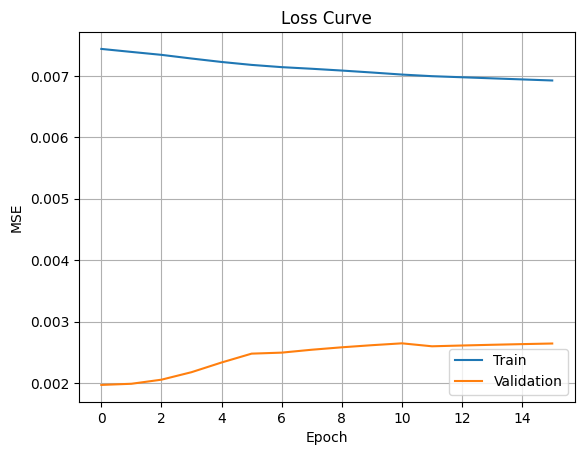

In [72]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

Load best model and evaluate

In [73]:
model = keras.models.load_model(model_dir / 'streamflow_model.keras')

predicted = model.predict(X_test).flatten()

predicted_denorm = scaler.inverse_transform(
    np.vstack([test_data['NWM_streamflow'].values, predicted]).T
)[:, 1]

usgs_true_denorm = scaler.inverse_transform(
    np.vstack([test_data['NWM_streamflow'].values, y_test]).T
)[:, 1]

nwm_denorm = scaler.inverse_transform(
    np.vstack([test_data['NWM_streamflow'].values, test_data['NWM_streamflow'].values]).T
)[:, 1]

22708/22708 ━━━━━━━━━━━━━━━━━━━━ 13s 581us/step


Metrics and visualization

In [74]:
rmse_nwm = np.sqrt(mean_squared_error(usgs_true_denorm, nwm_denorm))
rmse_model = np.sqrt(mean_squared_error(usgs_true_denorm, predicted_denorm))

r2_nwm = r2_score(usgs_true_denorm, nwm_denorm)
r2_model = r2_score(usgs_true_denorm, predicted_denorm)

print(f"NWM RMSE: {rmse_nwm:.4f}, LSTM RMSE: {rmse_model:.4f}")
print(f"NWM R²: {r2_nwm:.4f}, LSTM R²: {r2_model:.4f}")

NWM RMSE: 16.8668, LSTM RMSE: 14.0177
NWM R²: -0.4489, LSTM R²: -0.0008


Plot by lead time

In [75]:
test_data['predicted'] = predicted_denorm
test_data['USGS_true'] = usgs_true_denorm
test_data['NWM_true'] = nwm_denorm
test_data['lead_time_hr'] = test_data['lead_time'] * 18

for lt in sorted(test_data['lead_time_hr'].unique()):
    subset = test_data[test_data['lead_time_hr'] == lt]
    rmse = np.sqrt(mean_squared_error(subset['USGS_true'], subset['predicted']))
    print(f"Lead time {int(lt)}h: RMSE = {rmse:.3f}")

Lead time 1h: RMSE = 13.936
Lead time 2h: RMSE = 13.951
Lead time 3h: RMSE = 13.969
Lead time 4h: RMSE = 13.989
Lead time 5h: RMSE = 14.010
Lead time 6h: RMSE = 14.028
Lead time 7h: RMSE = 14.045
Lead time 8h: RMSE = 14.051
Lead time 9h: RMSE = 14.051
Lead time 10h: RMSE = 14.049
Lead time 11h: RMSE = 14.046
Lead time 12h: RMSE = 14.045
Lead time 13h: RMSE = 14.037
Lead time 14h: RMSE = 14.032
Lead time 15h: RMSE = 14.027
Lead time 16h: RMSE = 14.022
Lead time 17h: RMSE = 14.017
Lead time 18h: RMSE = 14.011


C:\Users\John Waugh\AppData\Local\Temp\ipykernel_12880\2996103297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted'] = predicted_denorm
C:\Users\John Waugh\AppData\Local\Temp\ipykernel_12880\2996103297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['USGS_true'] = usgs_true_denorm
C:\Users\John Waugh\AppData\Local\Temp\ipykernel_12880\2996103297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

Time series plot

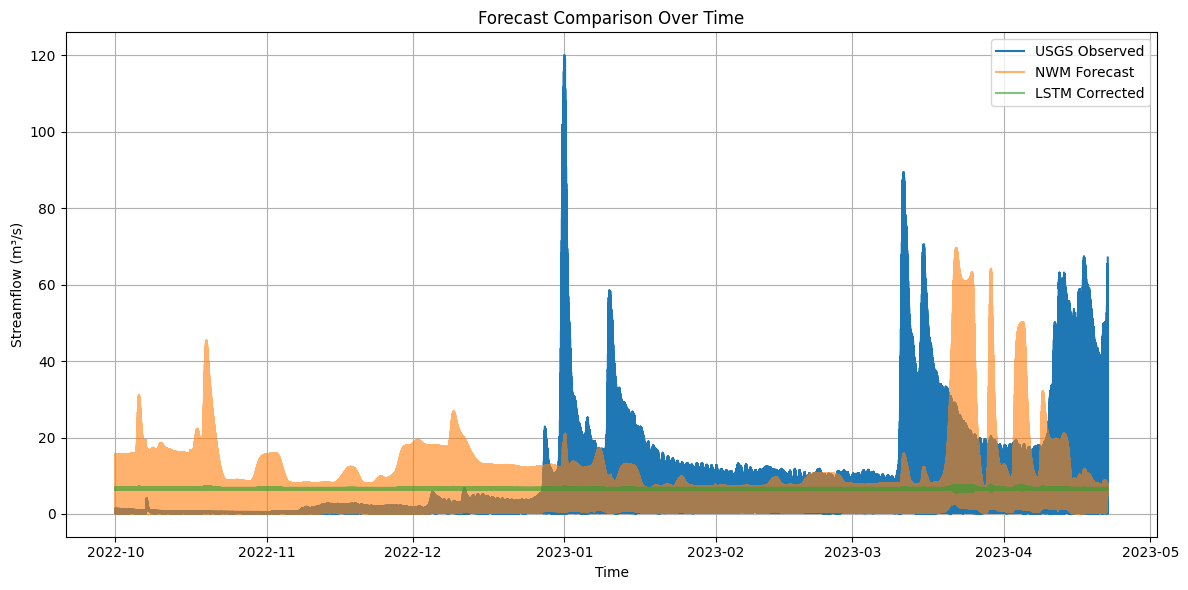

In [76]:
plt.figure(figsize=(12,6))
plt.plot(test_data['model_output_valid_time'], test_data['USGS_true'], label='USGS Observed')
plt.plot(test_data['model_output_valid_time'], test_data['NWM_true'], label='NWM Forecast', alpha=0.6)
plt.plot(test_data['model_output_valid_time'], test_data['predicted'], label='LSTM Corrected', alpha=0.6)
plt.title("Forecast Comparison Over Time")
plt.xlabel("Time")
plt.ylabel("Streamflow (m³/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()